# HR Аналитика

## Описание

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.<br><br>

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

## Цель исследования

Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. <br><br>

Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Загрузка библиотек

In [1]:
!pip install shap -q;
!pip install phik -q;
!pip install -U scikit-learn;

In [2]:
import shap 
import pandas as pd
import numpy as np 
import phik
from matplotlib import pyplot as plt
import seaborn as sns 
from scipy import stats as st 

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectKBest, f_classif

# Задача 1: предсказание уровня удовлетворённости сотрудника

## Шаг 1. Загрузка данных

In [3]:
df = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test = pd.read_csv('/datasets/test_features.csv')
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
print(X_test.info())
display(X_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
print(y_test.info())
display(y_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


### Вывод:
1. Есть пропуски в таблице df - поля dept и level и есть пропуски в таблице X_test - поля dept и level
2. Строки, судя по id, в таблицах X_test и y_test не соответствуют друг другу. Требуется скорректировать перед обучением

## Шаг 2. Предобработка данных

In [7]:
# Поиск полных дубликатов
df_list = [df, X_test, y_test]

for name in df_list:
    print(name.duplicated().sum())

0
0
0


Дубликатов не обранужено

In [8]:
X_test = X_test.sort_values(by='id').reset_index(drop=True)
y_test = y_test.sort_values(by='id').reset_index(drop=True)
display(X_test.head())
display(y_test.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


,id,job_satisfaction_rate
0,100298,0.80
1,100480,0.84
2,100503,0.79
3,100610,0.75
4,100692,0.69


### Вывод:
1. Полные дубликаты не обнаружены
2. id в X_test и y_test отсортированы, чтобы строки для наблюдений (сотрудников) соответствовали
3. Пропуски будут заполнены далее в пайплайнах

## Шаг 3. Исследовательский анализ данных

In [9]:
def hist_box(data, column):
    """Построение графиков распределения количественных признаков"""
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data[column])
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=data[column])

In [10]:
def bar_box(dataset, column):
    """Построение графиков распределения категоральных признаков"""
    plt.figure(figsize=(12,8))
    plt.title(f'Гистограмма распределения "{column}"')
    sns.countplot(x=dataset[column]);
    plt.xlabel(f'Значение параметра {column}')
    plt.ylabel('Частота')

In [11]:
num_col = ['salary', 'job_satisfaction_rate']
cat_col = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations',
          'supervisor_evaluation']

### Исследовательский анализ df

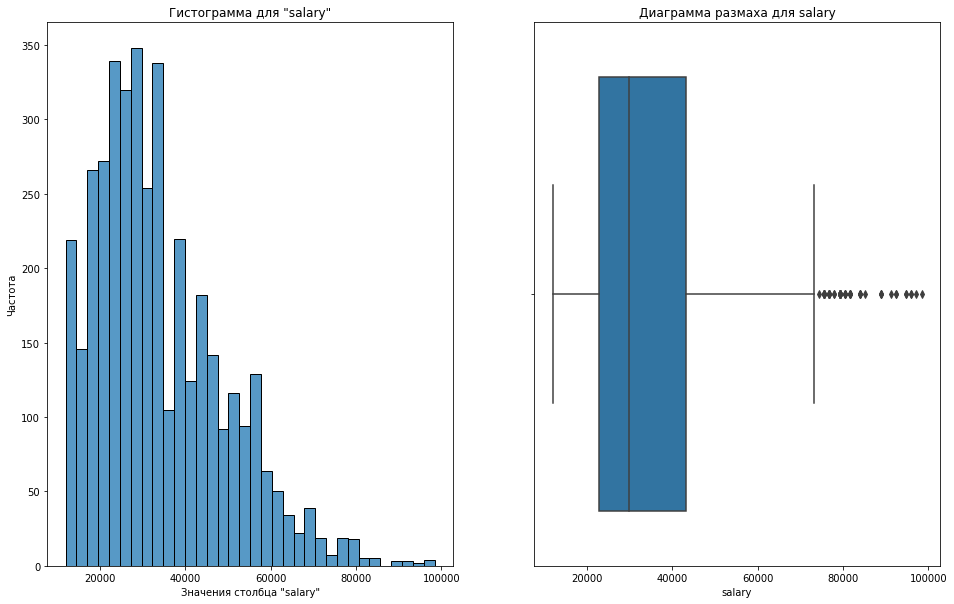

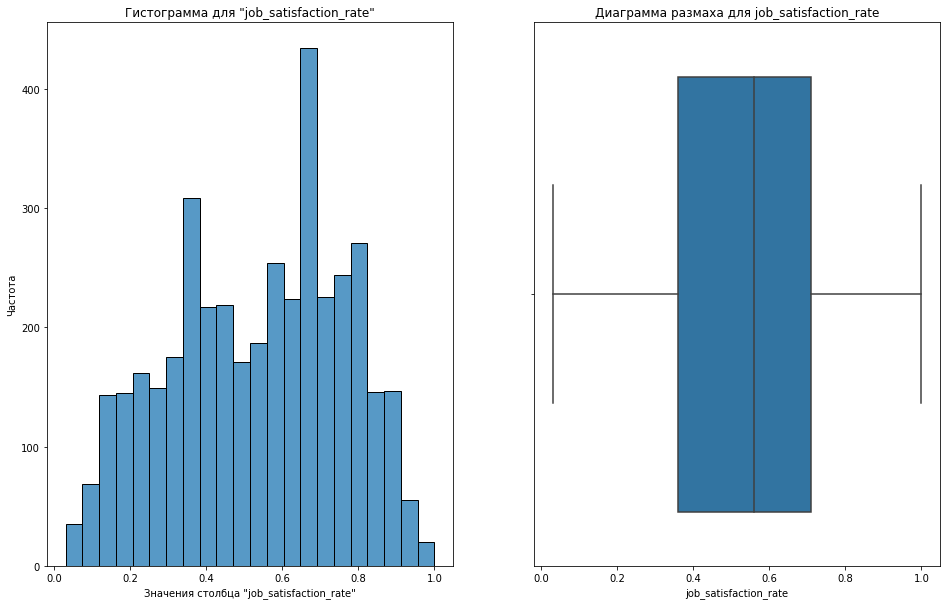

In [12]:
# df числовые признаки
for name in num_col:
    hist_box(df, name)

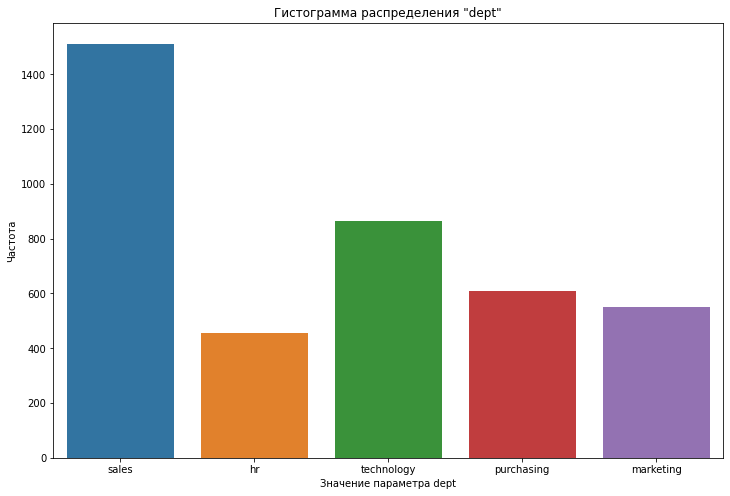

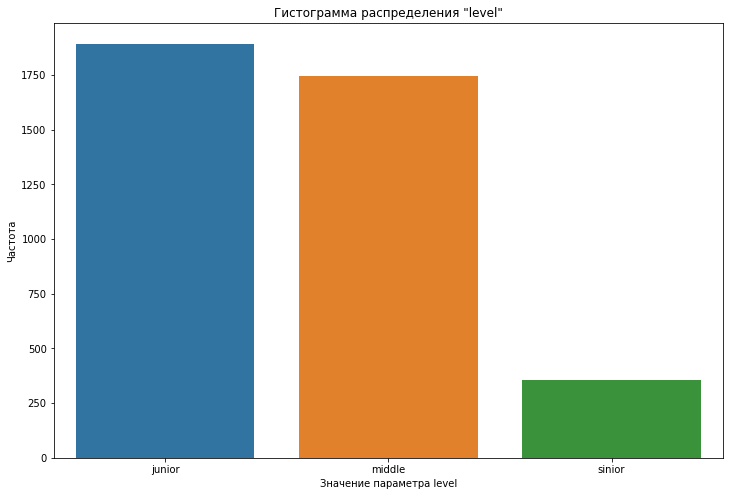

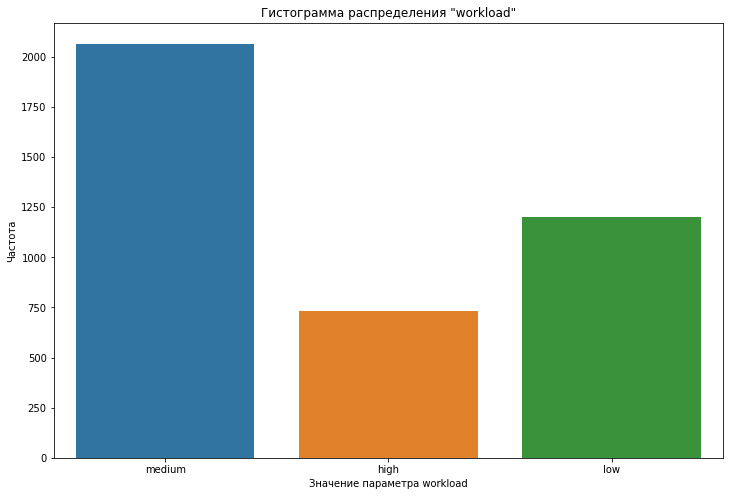

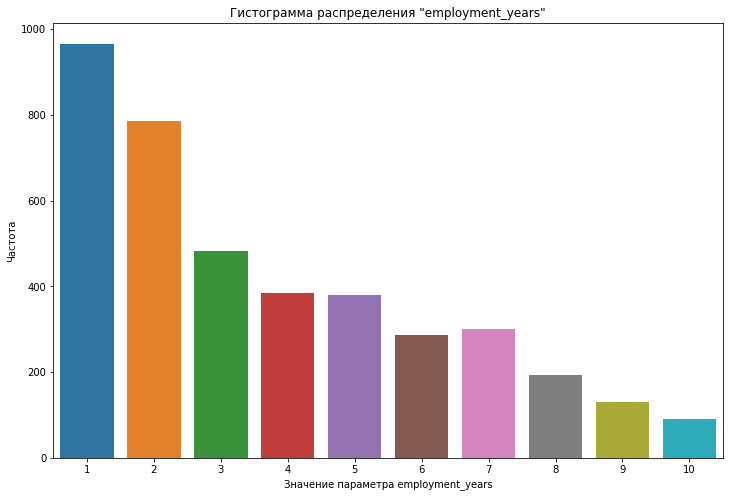

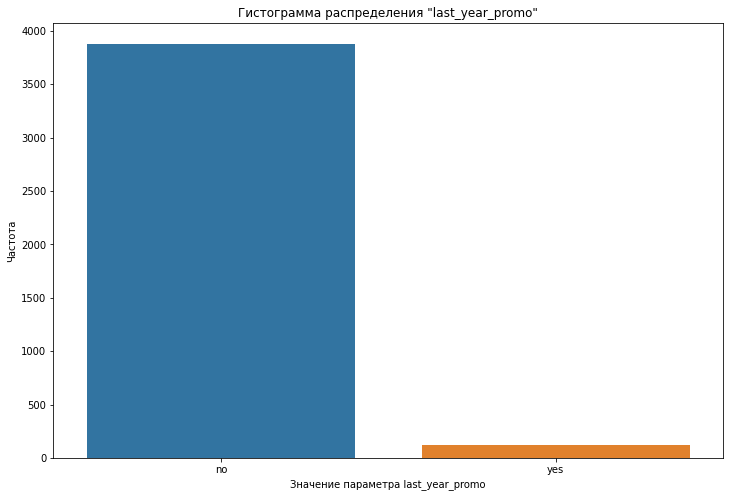

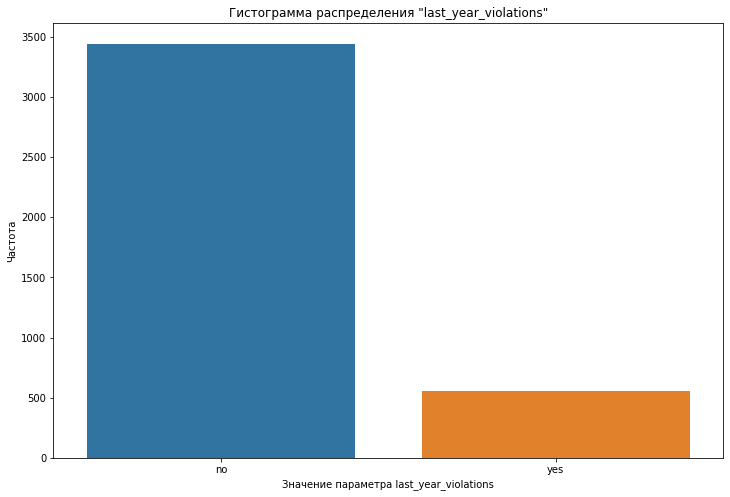

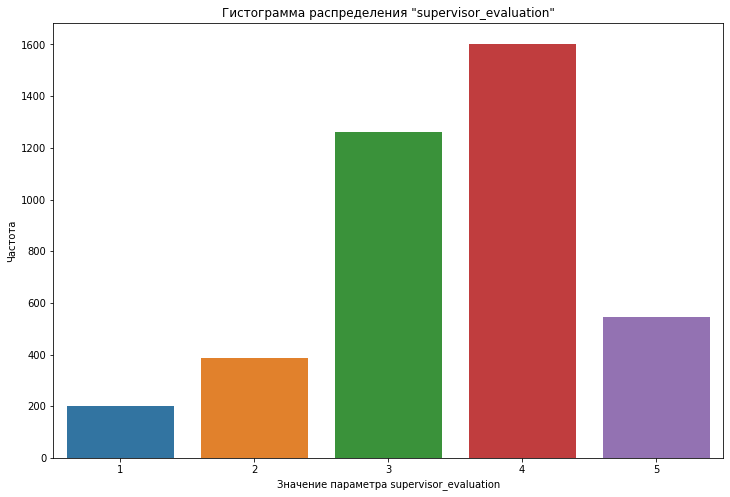

In [13]:
# df категоральные признаки
for name in cat_col:
    bar_box(df, name)

#### Вывод:
1. Признак salary имеет смещенное влево распределение. Думаю, что большие значения стоит оставить. Возможно это топ-менеджеры или какие-то дорогие специалисты (или просто хорошие продажники)
2. По признаку supervisor_evaluation понятно, что большинство сотрудников работает как минимум удовлетворительно.
3. В других признаках ничего аномального не замечено.

### Исследовательский анализ X_test

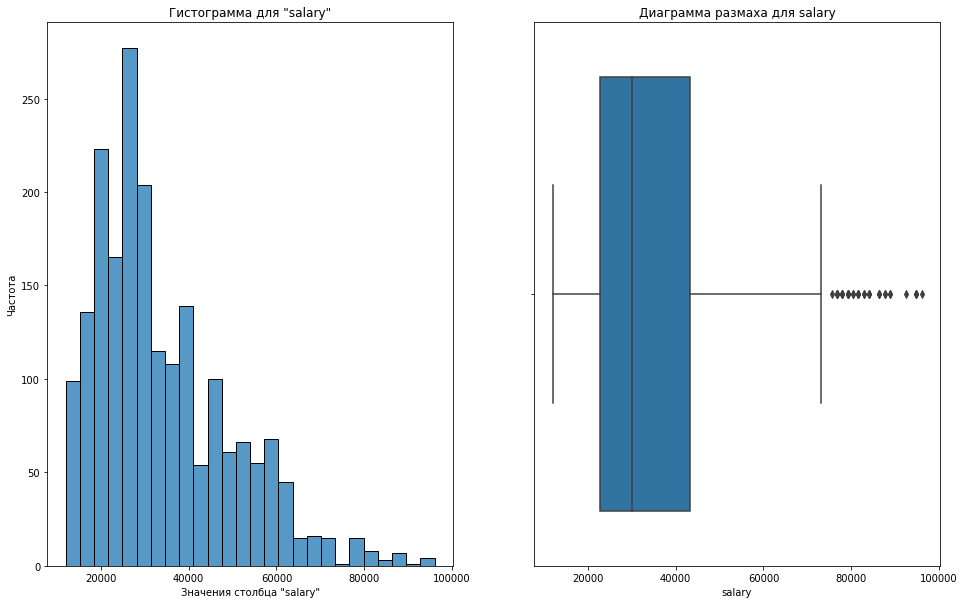

In [14]:
# X_test числовые признаки
hist_box(X_test, 'salary')

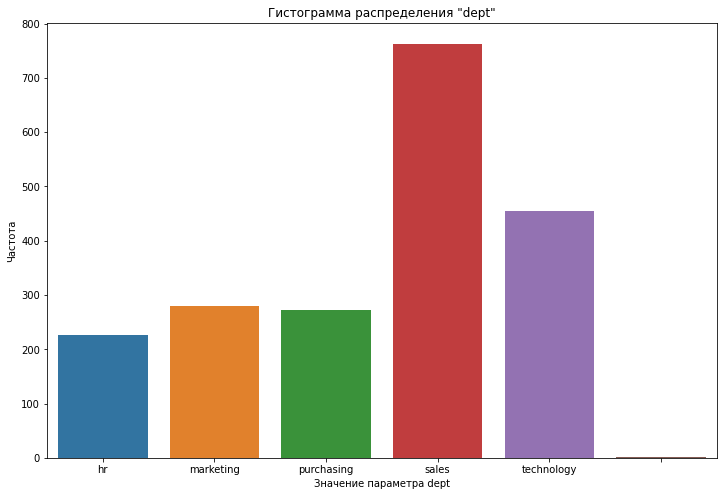

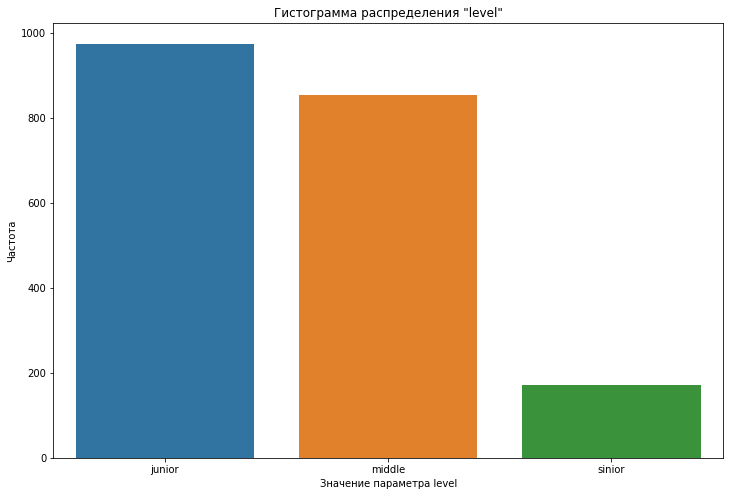

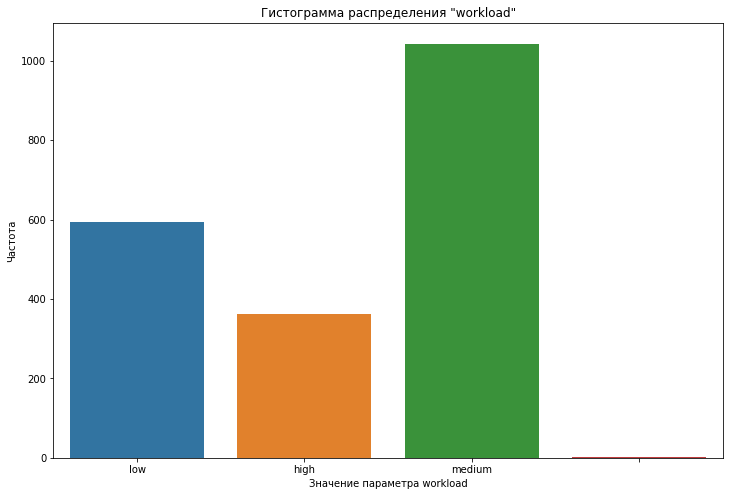

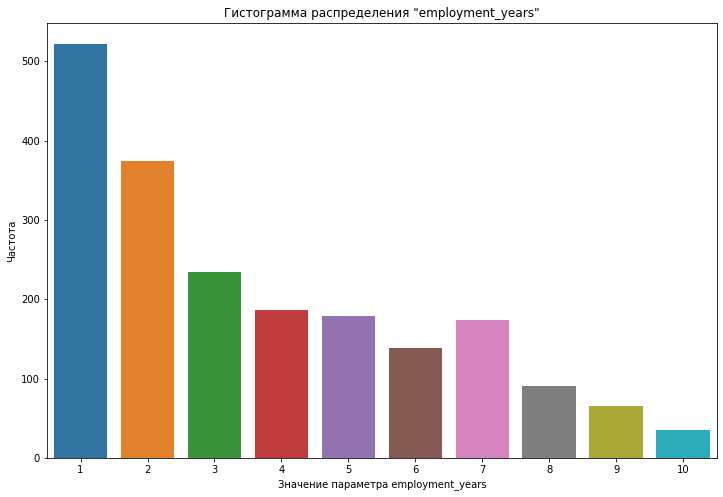

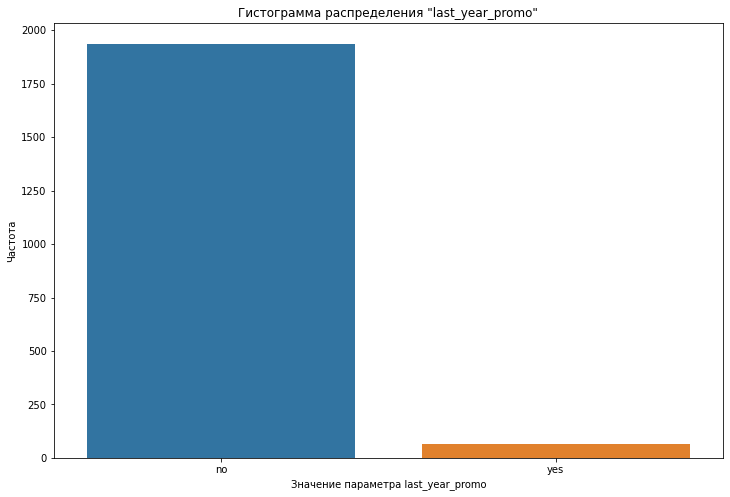

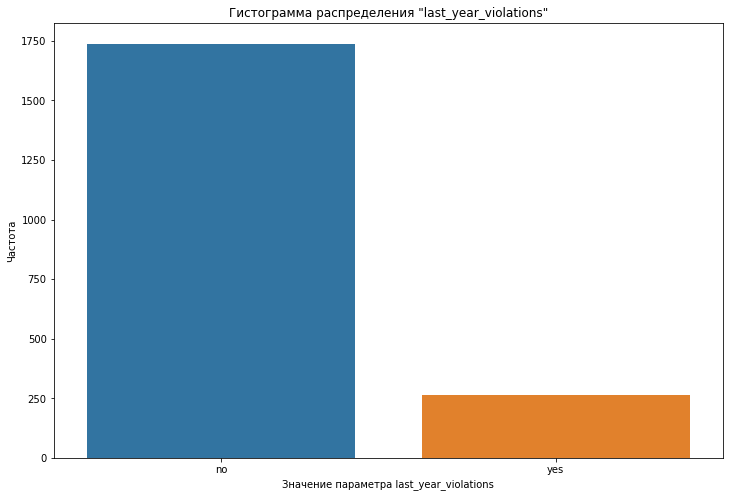

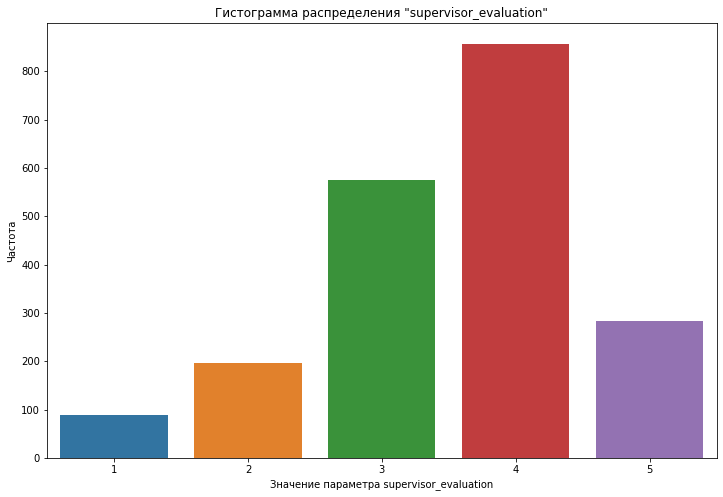

In [15]:
# X_test категоральные признаки
for name in cat_col:
    bar_box(X_test, name)

В workload и dept есть значения, похожие на пробел ' '. Заменю на частовстречающиеся 

In [16]:
display(X_test[X_test['dept'] == ' '])
display(X_test[X_test['workload'] == ' '])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1609,822186,,middle,medium,3,no,no,4,38400


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1100,590867,marketing,junior,,4,no,no,4,28800


In [17]:
X_test['dept'] = X_test['dept'].replace(' ', 'sales')
X_test['workload'] = X_test['workload'].replace(' ', 'medium')

#### Вывод:
1. Заменены пробелы в полях dept и workload на самые частовстречаемые значения (всего таких 2 строки)
2. В других признаках ничего аномального не замечено.

### Корреляция

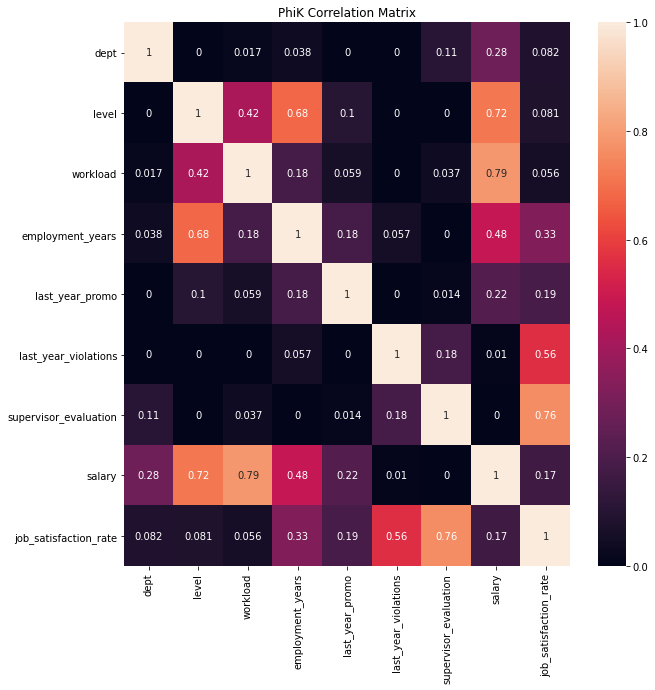

In [18]:
#df
corr_matrix = df.drop(['id'], axis=1).phik_matrix(interval_cols=['salary', 
                                                                   'job_satisfaction_rate'])
 
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)
plt.title('PhiK Correlation Matrix')
plt.show()

Видна высокая корреляция между:<br><br>
1. Грейдом и проработанными годами
2. Грейд и зарплата
3. Нагрузка и зарплата
4. Удовлетворенностью (целевой признак) и оценкой работы.<br><br>

При этом нет признаков, создающий мультиколлинеарность

In [19]:
X_test

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000
...,...,...,...,...,...,...,...,...,...
1995,997290,sales,sinior,medium,7,no,no,4,58800
1996,998548,marketing,junior,medium,2,no,no,4,32400
1997,998762,technology,junior,low,3,no,no,3,22800
1998,998900,marketing,middle,medium,7,no,no,3,45600


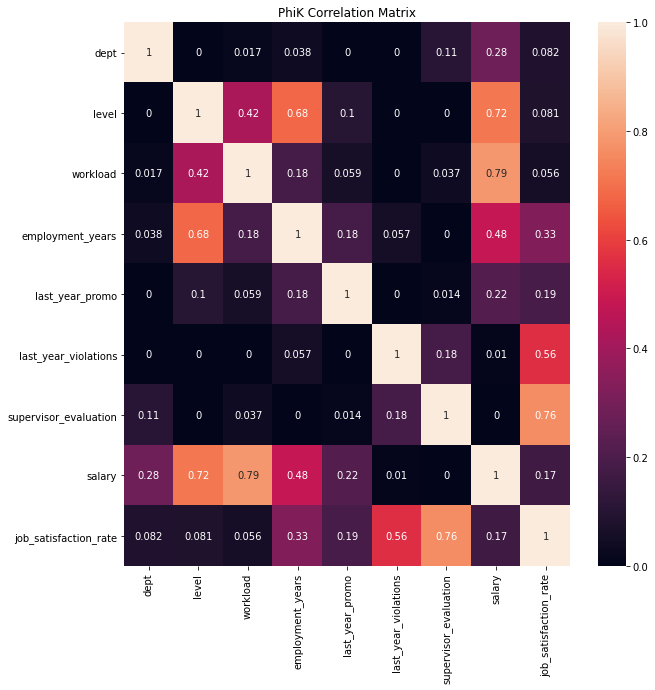

In [20]:
# X_test
corr_matrix_test = X_test.drop(['id'], axis=1).phik_matrix(interval_cols=['salary'])

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)
plt.title('PhiK Correlation Matrix')
plt.show()

Между тренировочными и тестовыми данными практически нет разницы в плане корреляции.

## Шаг 4. Подготовка данных

In [21]:
df_train = df.drop('id', axis=1)
df_train.duplicated().sum() #При удалении id могли возникнуть строки с равными условиями

245

In [22]:
df_train = df_train.drop_duplicates() 

In [23]:
df_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
1,hr,junior,high,2,no,no,5,38400,0.76
2,sales,junior,low,1,no,no,2,12000,0.11
3,technology,junior,low,4,no,no,2,18000,0.37
4,hr,junior,medium,1,no,no,3,22800,0.20


In [24]:
X_train = df_train.drop('job_satisfaction_rate', axis=1)
y_train = df_train['job_satisfaction_rate']
X_test = X_test.drop('id', axis=1)
y_test = y_test['job_satisfaction_rate']

In [25]:
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']

ord_col = ['level','workload']

num_col = ['employment_years', 'supervisor_evaluation', 'salary']

In [26]:
# Сборка пайплайнов
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan, 
                       strategy='most_frequent')), 
        ('ohe', 
         OneHotEncoder(drop='first', 
                       handle_unknown='ignore', 
                       sparse_output=False))
    ]
)

In [27]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [28]:
# Подготовка данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)

In [29]:
# Итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [30]:
# Так как по условию есть оговорка, что нужно взять линейную и дерево решений
param_distributions = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
    
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(2, 12),
        'models__min_samples_leaf': range(2,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
] 

## Шаг 5. Обучение моделей

In [31]:
# создание метрики SMAPE

def SMAPE(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))))
                                      
SMAPE_score = make_scorer(SMAPE, greater_is_better=False)

In [32]:
grid = GridSearchCV(
    pipe_final,
    param_grid=param_distributions,
    cv=5,
    scoring=SMAPE_score,
    n_jobs=-1)

In [33]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(2, 12),
                          'models__min_samples_leaf': range(2, 6),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(SMAPE, greater_is_better=False, response_method='predict'))

In [34]:
print('Метрика SMAPE для лучшей модели:\n', round(grid.best_score_, 2)) 
print('\nЛучшая модель и её параметры:\n\n', grid.best_params_) 

Метрика SMAPE для лучшей модели:
 -15.61

Лучшая модель и её параметры:

 {'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 11, 'models__min_samples_leaf': 3, 'preprocessor__num': StandardScaler()}


In [35]:
y_pred = grid.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {round(SMAPE(y_test, y_pred), 2)}')

Метрика SMAPE на тестовой выборке: 14.08


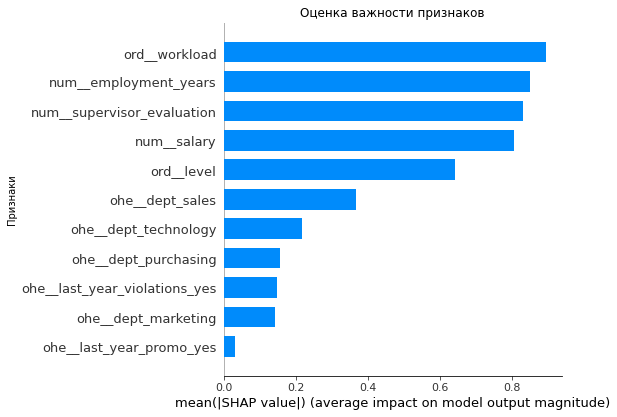

In [36]:
# Построение важности признаком по SHAP
X_encoded = grid.best_estimator_['preprocessor'].fit_transform(X_train)

model = grid.best_estimator_['models'].fit(X_encoded, y_train)
explainer = shap.PermutationExplainer(model, X_encoded)


labels = grid.best_estimator_[:-1].get_feature_names_out()

plt.title('Оценка важности признаков')
plt.ylabel('Признаки')
shap.summary_plot(X_encoded, plot_type='bar', feature_names=labels) 

### Вывод:
1. Лучшей оказалась модель дерева решений с параметрами 'models__max_depth': 11, 'models__min_samples_leaf': 3, 'preprocessor__num': MinMaxScaler()
2. На тестовой выборке метрика SMAPE = 14.08. Это соответствует условию SMAPE <= 15
3. Самыми важными признаками оказались нагрузка, оценка руководителя и грейд
4. Дерево показало себя лучше, возможно, из-за того, что присутсвуют нелинейные связи между признаками

# Задача 2: предсказание увольнения сотрудника из компании

## Шаг 1. Загрузка данных

In [37]:
df_2 = pd.read_csv('/datasets/train_quit.csv')
X_test_2 = pd.read_csv('/datasets/test_features.csv')
y_test_2 = pd.read_csv('/datasets/test_target_quit.csv')

In [38]:
print(df_2.info())
display(df_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [39]:
print(X_test_2.info())
display(X_test_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [40]:
print(y_test_2.info())
display(y_test_2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


### Вывод:
1. Есть пропуски в таблице X_test_2 - поля dept и level
2. Строки, судя по id, в таблицах X_test_2 и y_test_2 не соответствуют друг другу. Требуется скорректировать перед обучением

## Шаг 2. Предобработка данных

In [41]:
# Поиск полных дубликатов
df_list = [df_2, X_test_2, y_test_2]

for name in df_list:
    print(name.duplicated().sum())

0
0
0


Полные дубликаты не обнаружены

In [42]:
X_test_2 = X_test_2.sort_values(by='id').reset_index(drop=True)
y_test_2 = y_test_2.sort_values(by='id').reset_index(drop=True)
display(X_test_2.head())
display(y_test_2.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


,id,quit
0,100298,no
1,100480,no
2,100503,no
3,100610,no
4,100692,no


### Вывод:
1. Полные дубликаты не обнаружены
2. id в X_test_2 и y_test_2 отсортированы, чтобы строки для наблюдений (сотрудников) соответствовали
3. Пропуски будут заполнены далее в пайплайнах

In [43]:
df_2

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


## Шаг 3. Исследовательский анализ данных

### Исследовательский анализ df_2

In [44]:
num_col = ['salary']
cat_col = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations',
          'supervisor_evaluation', 'quit']

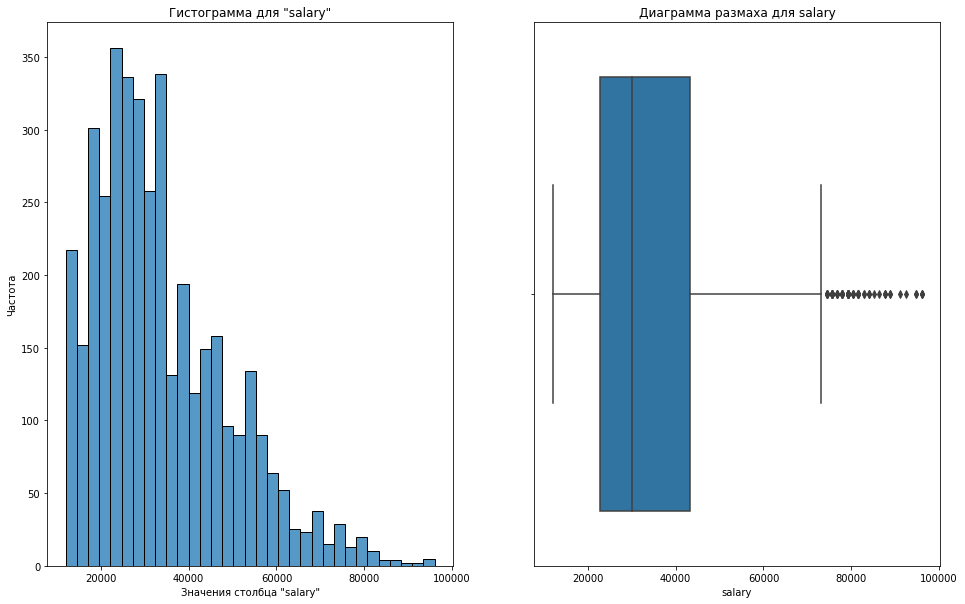

In [45]:
# df_2 числовые признаки
for name in num_col:
    hist_box(df_2, name)

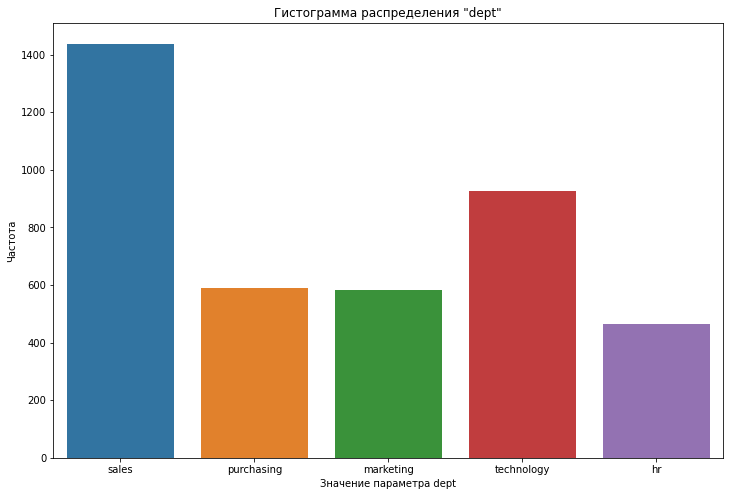

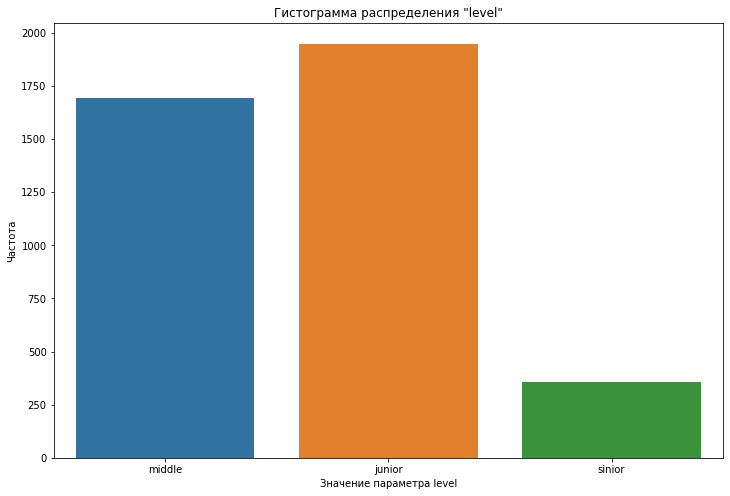

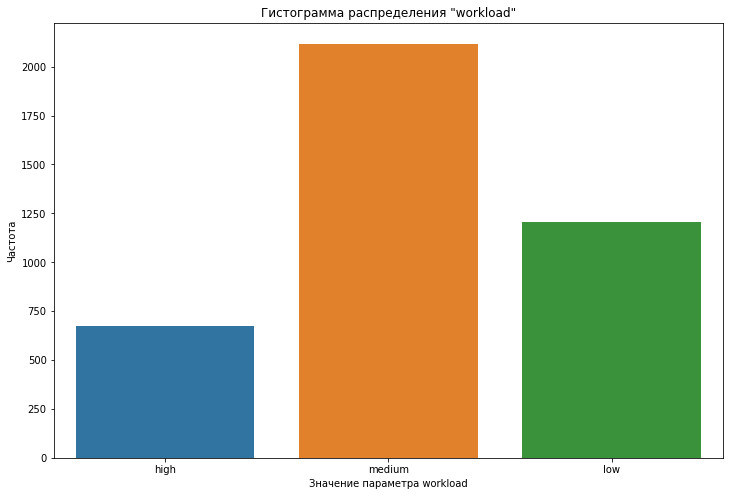

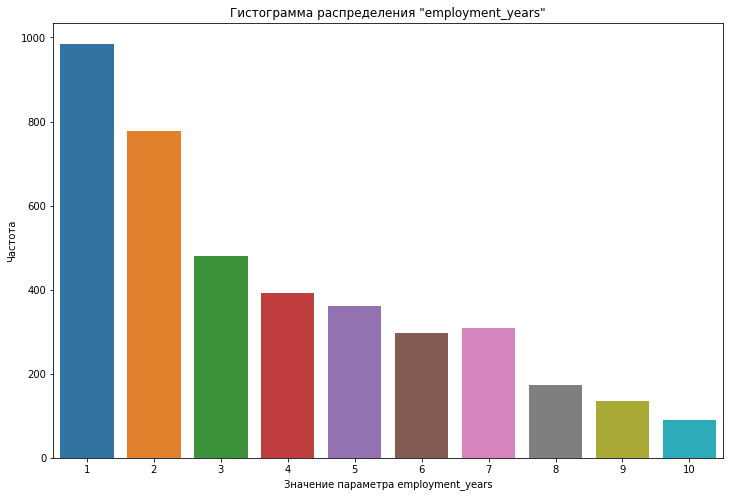

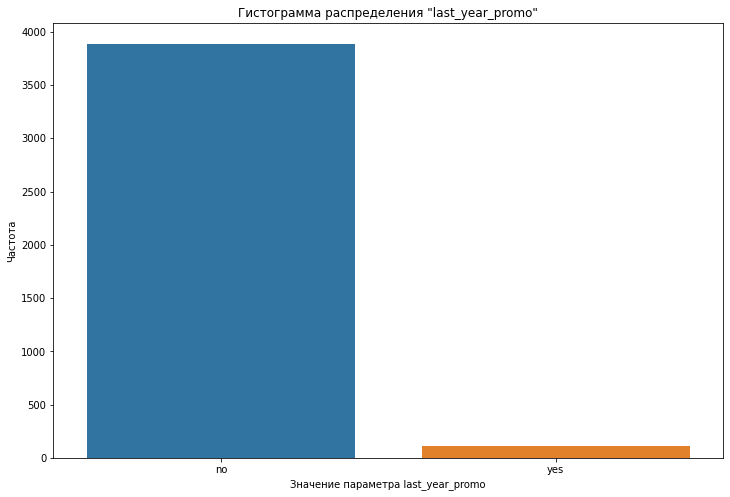

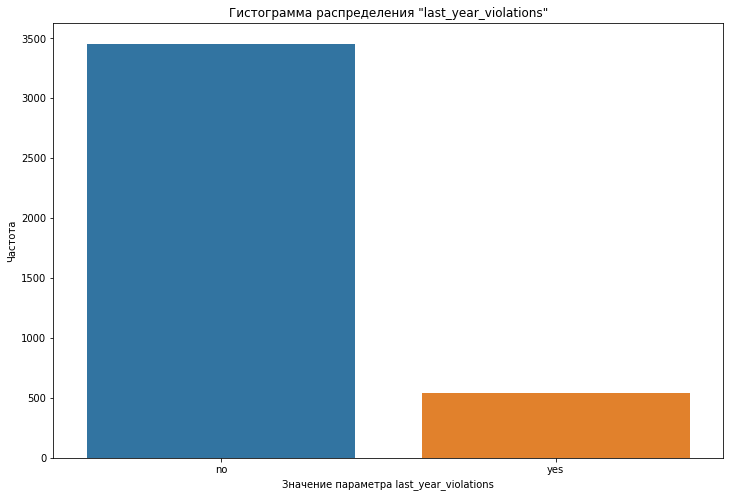

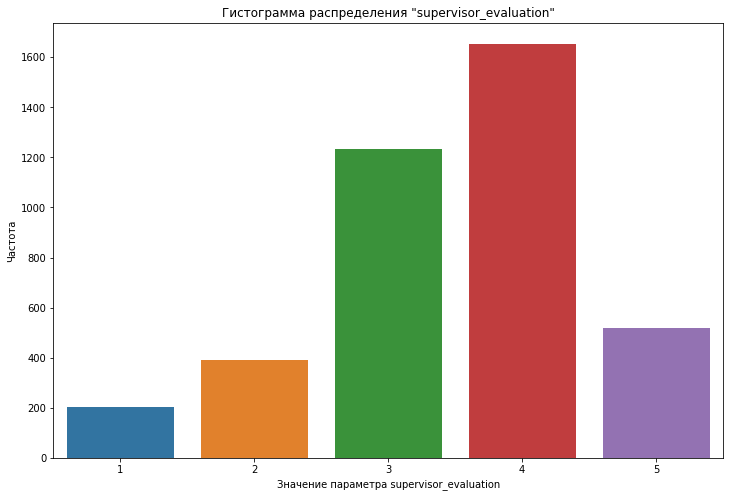

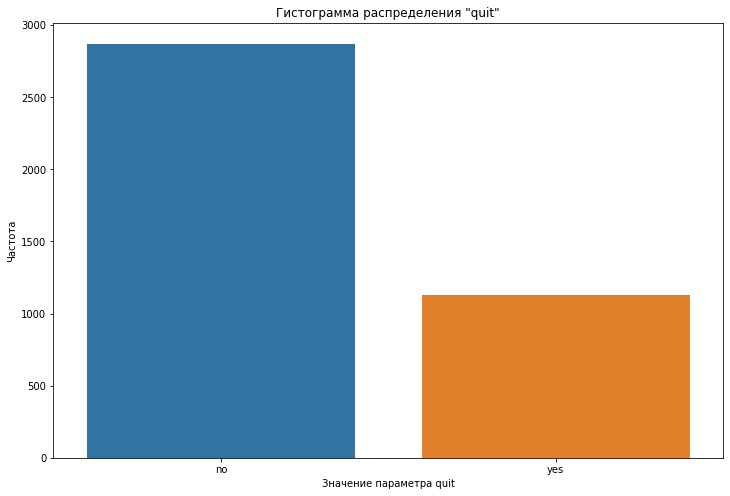

In [46]:
# df_2 категоральные признаки
for name in cat_col:
    bar_box(df_2, name)

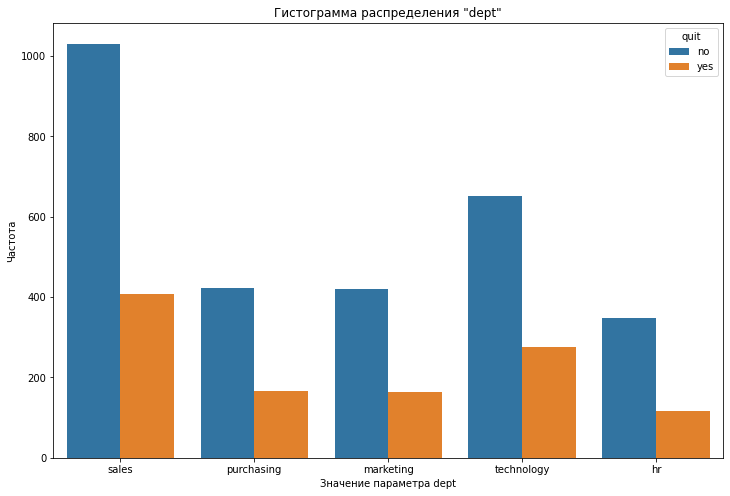

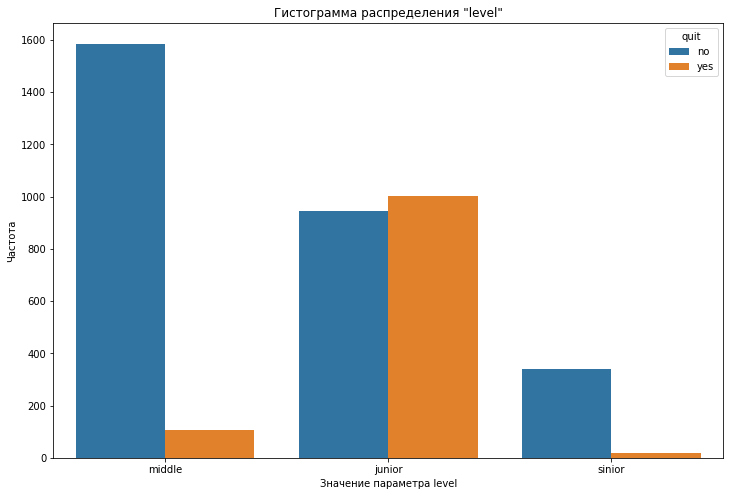

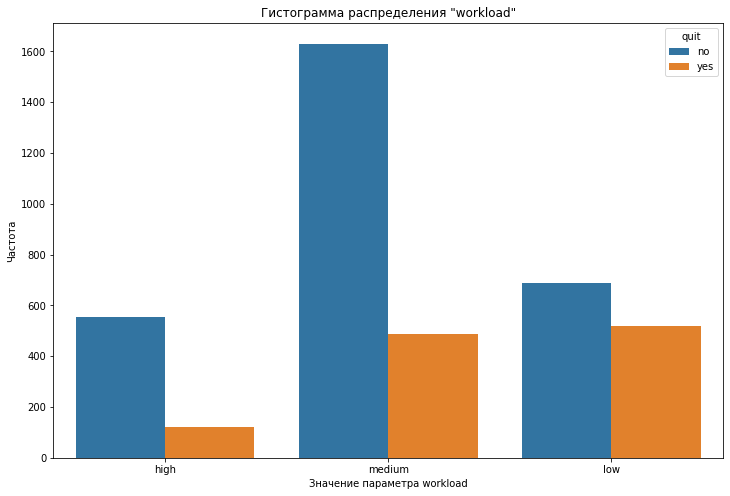

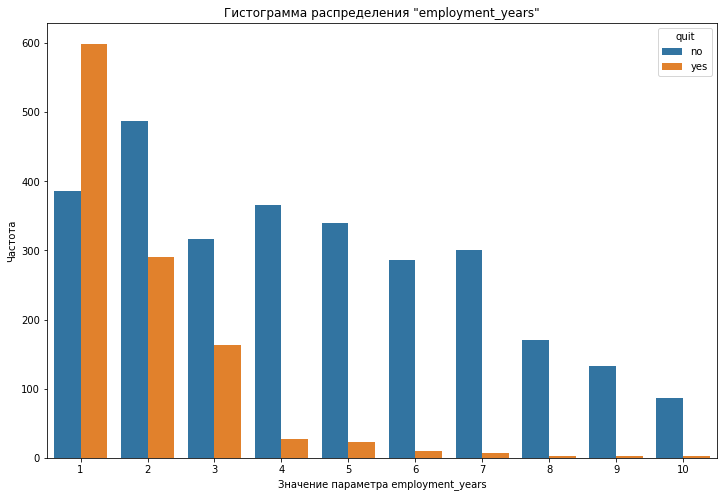

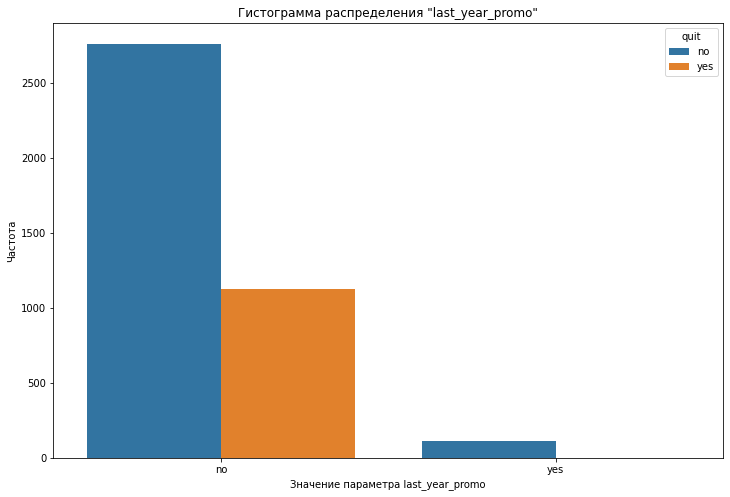

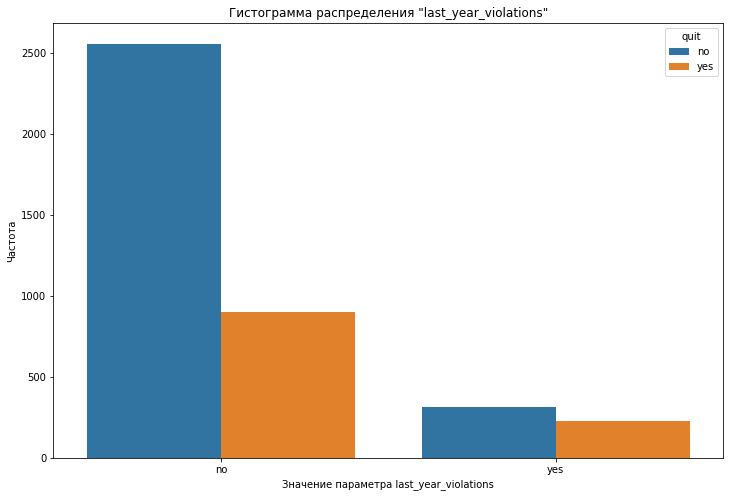

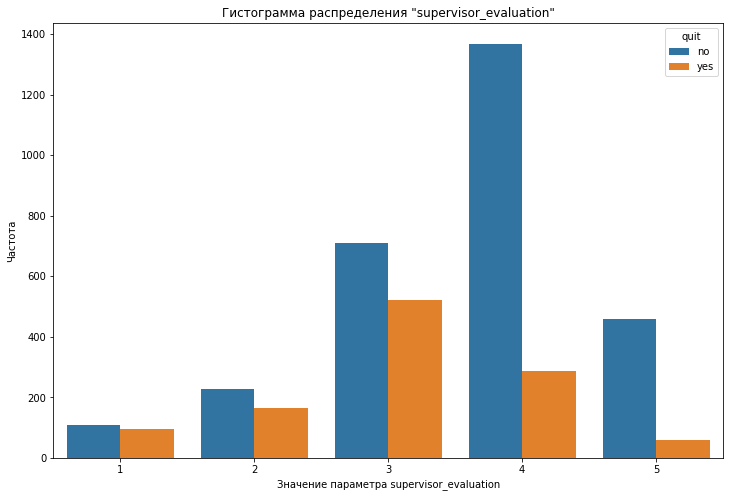

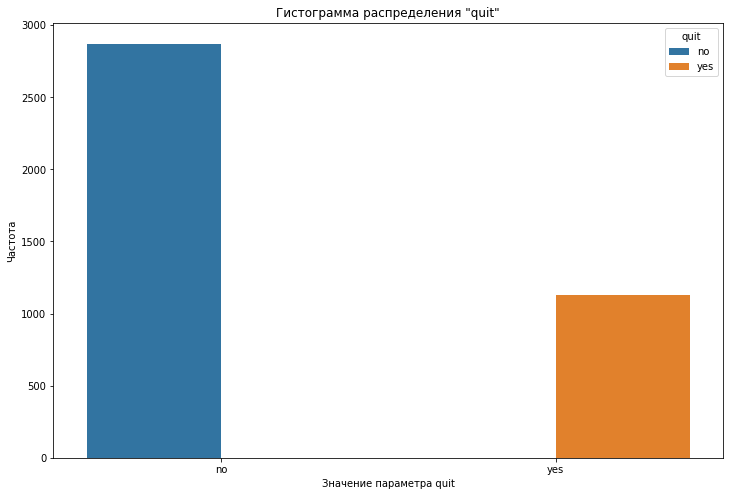

In [47]:
for name in cat_col:
    plt.figure(figsize=(12,8))
    plt.title(f'Гистограмма распределения "{name}"')
    sns.countplot(data=df_2, x=name, hue='quit')
    plt.xlabel(f'Значение параметра {name}')
    plt.ylabel('Частота')

#### Вывод:
1. Данные распределены так же как и в предыдущем датасете. Особо изменений нет
2. Чаще всего увольняются сотрудники с младших позиций
3. Чаще увольняются в первые 3 года работы в компании (в 1й год особенно).
4. Если повысили - не увольняются. Следует обратить на этот момент внимание при построении модели.

### Исследовательский анализ X_test_2

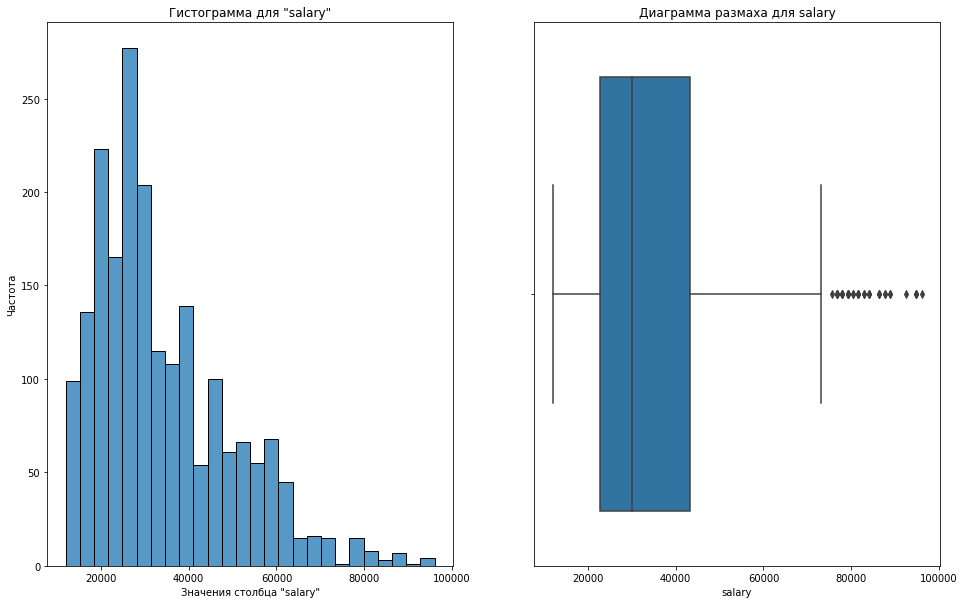

In [48]:
# X_test_2 числовые признаки
for name in num_col:
    hist_box(X_test_2, name)

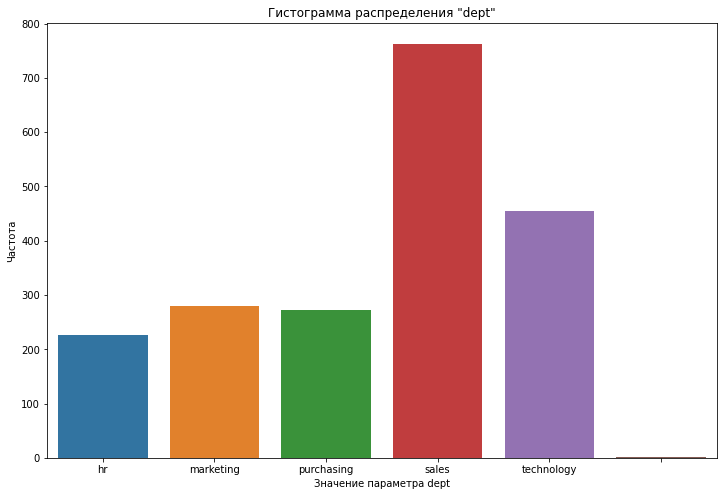

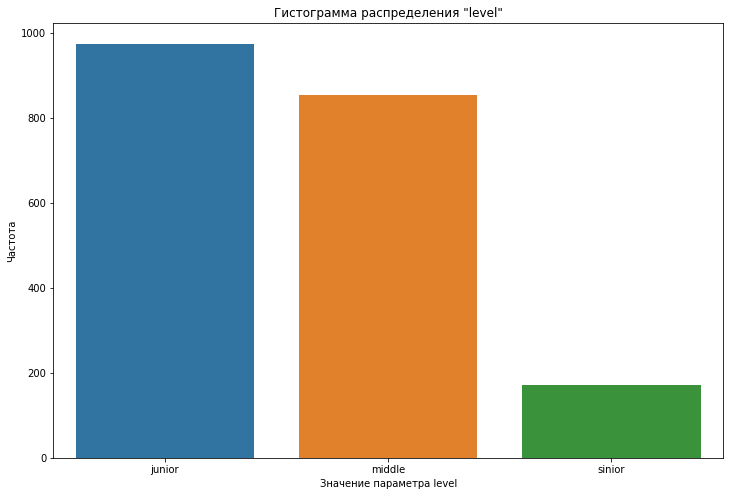

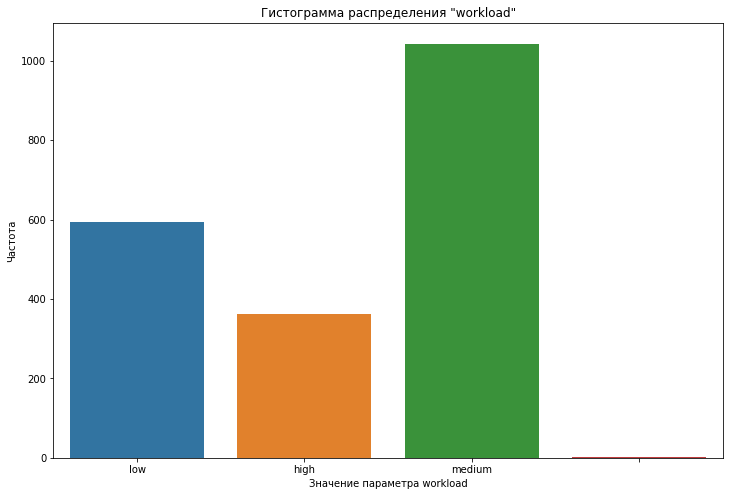

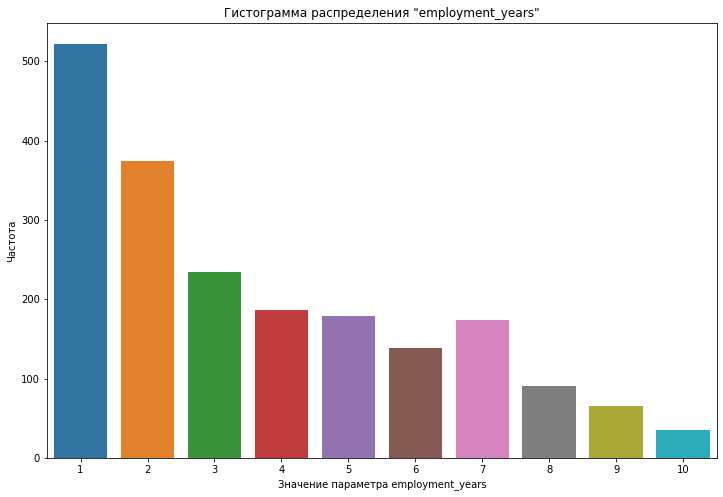

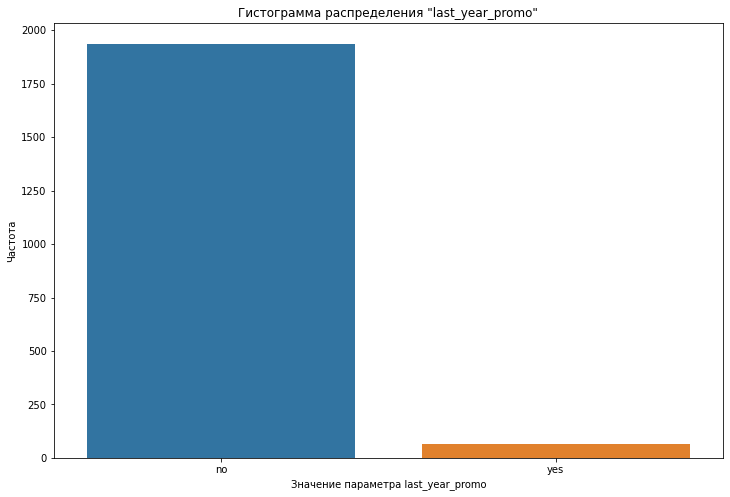

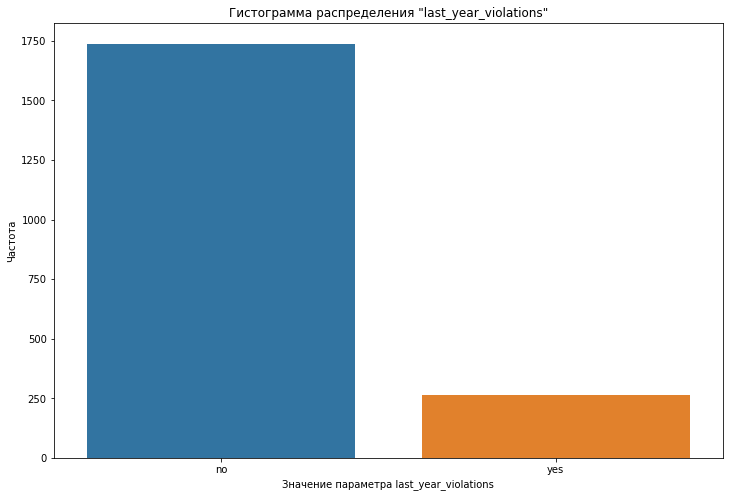

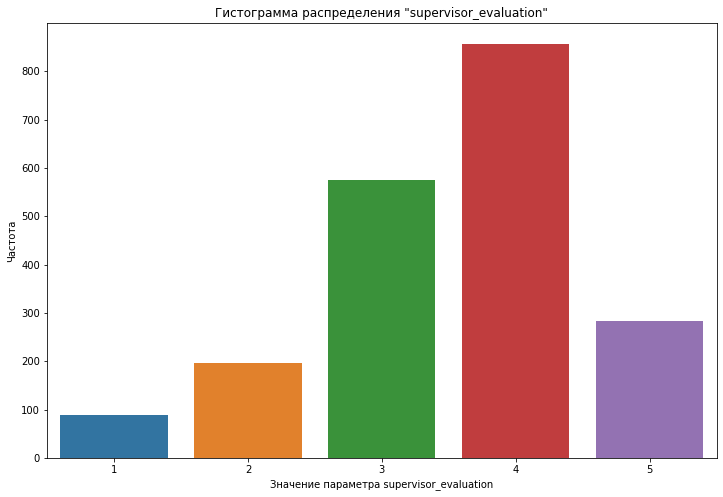

In [49]:
cat_col = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations',
          'supervisor_evaluation']
# X_test_2 категоральные признаки
for name in cat_col:
    bar_box(X_test_2, name)

In [50]:
display(X_test_2[X_test_2['dept'] == ' '])
display(X_test_2[X_test_2['workload'] == ' '])
X_test_2['dept'] = X_test_2['dept'].replace(' ', 'sales')
X_test_2['workload'] = X_test_2['workload'].replace(' ', 'medium')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1609,822186,,middle,medium,3,no,no,4,38400


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1100,590867,marketing,junior,,4,no,no,4,28800


Портрет:<br><br>
1. Работают в компании меньше (до 3 лет. Чаще в 1 год)
2. В основном младшая позиция (Junior)
3. Обычно у них low и medium уровень нагрузки
4. Без повышений
5. Оценка работы руководителем чаще удовлетворительная и ниже

#### Вывод:
1. Данные распределены аналогично с тренировочными данными

### Добавление признака job_satisfaction_rate

In [51]:
X_test_2['job_satisfaction_rate'] = y_test
X_test_2['quit'] = y_test_2['quit']
X_test_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,100298,hr,junior,low,2,no,no,4,19200,0.80,no
1,100480,marketing,junior,low,4,no,no,4,16800,0.84,no
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
3,100610,sales,middle,medium,5,no,no,4,43200,0.75,no
4,100692,sales,middle,high,6,no,no,4,48000,0.69,no


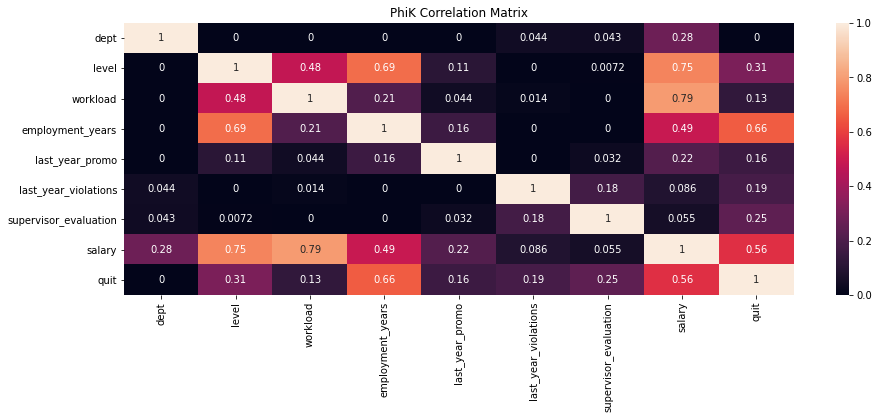

In [52]:
corr_matrix = df_2.drop(['id'], axis=1).phik_matrix(interval_cols=['salary'])

plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True)
plt.title('PhiK Correlation Matrix')
plt.show()

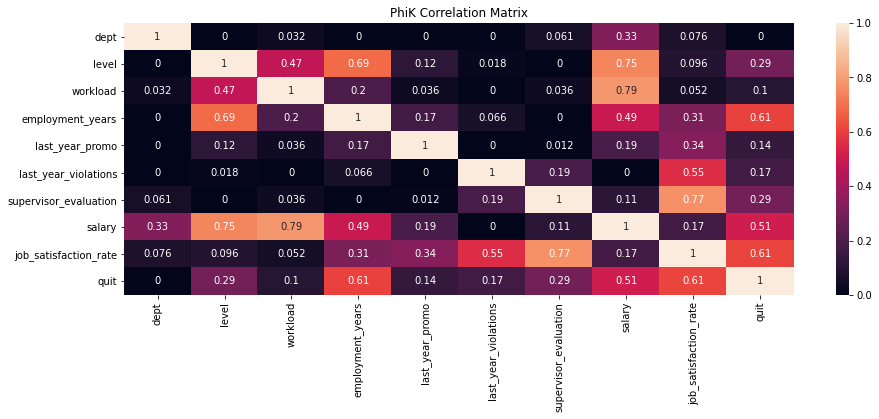

In [53]:
corr_matrix = X_test_2.drop(['id'], axis=1).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

plt.figure(figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True)
plt.title('PhiK Correlation Matrix')
plt.show()

#### Вывод:
1. Данные имеют схожую корреляцию, как из 1 части
2. Уход и удовлетворенность сотрудника имеют высокую корреляцию между собой - 0.61

## Шаг 4. Добавление нового входного признака

In [54]:
df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [55]:
df_2.query('id==155278')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit


In [56]:
df_train_2 = df_2.drop('id', axis=1)
df_train_2.duplicated().sum() #При удалении id могли возникнуть строки с равными условиями

1413

In [57]:
df_train_2 = df_train_2.drop_duplicates().reset_index(drop=True)

Убираю департамент, так как нет связи с целевым признаком и это снижает качество

In [58]:
X_train_2 = df_train_2.drop('quit', axis=1)
# Так как пользователи из тренировочных выборок для 1 части и текущей не совпадают, то предскажем
y = grid.predict(X_train_2) 

X_train_2['job_satisfaction_rate'] = y
X_train_2 = X_train_2.drop('dept', axis=1)
X_train_2.head()

,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,middle,high,2,no,no,4,54000,0.638070
1,junior,medium,2,no,no,4,27600,0.839155
2,middle,medium,5,no,no,1,37200,0.369167
3,junior,medium,2,no,yes,3,24000,0.350000
4,junior,medium,2,no,no,5,25200,0.797857


In [60]:
y_train_2 = df_train_2['quit']
X_test_2 = X_test_2.drop(['id', 'quit', 'dept'], axis=1)
y_test_2 = y_test_2['quit']

## Шаг 5. Подготовка данных

In [61]:
ohe_col_2 = [#'dept', 
    'last_year_promo', 'last_year_violations']

ord_col_2 = ['level','workload']

num_col_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [62]:
label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

In [63]:
# Сборка пайплайнов
ohe_pipe_2 = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan, 
                       strategy='most_frequent')), 
        ('ohe', 
         OneHotEncoder(drop='first', 
                       handle_unknown='ignore', 
                       sparse_output=False))
    ]
)

In [64]:
ord_pipe_2 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [65]:
# Подготовка данных
data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe_2, ohe_col_2),
        ('ord', ord_pipe_2, ord_col_2),
        ('num', StandardScaler(), num_col_2)
    ], 
    remainder='passthrough'
)

In [66]:
# Итоговый пайплайн
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier())
])

In [67]:
# Так как по условию есть оговорка, что нужно взять линейную и дерево решений
param_distributions_2 = [
    {
        'models': [LogisticRegression(random_state=42)],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }, 
    
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 12),
        'models__min_samples_leaf': range(2,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
    
] 

## Шаг 6. Обучение модели

In [68]:
grid_2 = GridSearchCV(
    pipe_final_2,
    param_grid=param_distributions_2,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1)

In [69]:
grid_2.fit(X_train_2, y_train_2)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[...
                                                'passthrough']},
                         {'models': [DecisionTreeClassifier(random_state=42)],
                          'models__max_depth': range(2, 12),
                          'models__min_samples_leaf': range(2, 6),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(1, 11),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [70]:
print('Метрика ROC_AUC для лучшей модели:\n', round(grid_2.best_score_, 3)) 
print('\nЛучшая модель и её параметры:\n\n', grid_2.best_params_) 

Метрика ROC_AUC для лучшей модели:
 0.905

Лучшая модель и её параметры:

 {'models': KNeighborsClassifier(), 'models__n_neighbors': 10, 'preprocessor__num': MinMaxScaler()}


In [71]:
y_pred_2 = grid_2.predict_proba(X_test_2)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_2, y_pred_2[:, 1]), 3)}')

Метрика ROC-AUC на тестовой выборке: 0.919


### Выводы

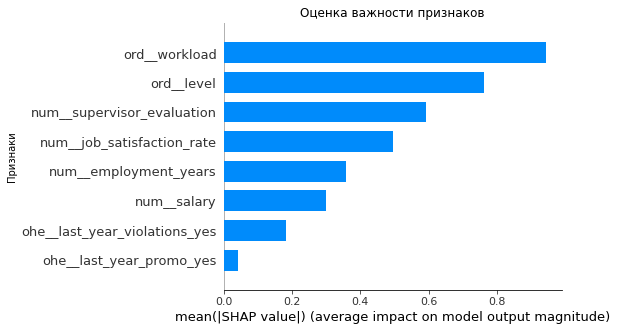

In [73]:
X_encoded_2 = grid_2.best_estimator_['preprocessor'].fit_transform(X_train_2)

model_2 = grid_2.best_estimator_['models'].fit(X_encoded_2, y_train_2)
explainer_2 = shap.PermutationExplainer(model_2, X_encoded_2)


labels_2 = grid_2.best_estimator_[:-1].get_feature_names_out()

plt.title('Оценка важности признаков')
plt.ylabel('Признаки')
shap.summary_plot(X_encoded_2, plot_type='bar', feature_names=labels_2) 

1. Лучшей оказалась модель ближайших соседей с параметрами 'models__n_neighbors': 10, 'preprocessor__num': MinMaxScaler()
2. На тестовой выборке метрика ROC_AUC = 0.919. Это соответствует условию ROC_AUC >= 0.91
3. Самыми важными признаками оказались нагрузка, грейд и оценка руководством

## Общий вывод:
В данном проекте были проанализированы данные о сотрудниках компании «Работа с заботой». Целью стояло прогнозирование уровня удовлетворенности и возможность ухода из компании.<br><br>

Была проведена подготовка данных:
 - Поиск и замена пропусков
 - Поиск явных дубликатов;
 - Сортировка тестовых выборок по id сотрудника.<br><br>
 
Для первой части задачи было обучено две модели - линейной регрессии и дерево решений для задач регрессии. Лучшей моделью оказалась модель дерева решений с метрикой SMAPE на тестовой выборке 14.08.<br><br>

С использованием этой модели был спрогнозирован уровень удовлетворенности сотрудников. А так же была применена для новой тренировочной выборки для введения нового признака - удовлетворенность<br><br>

Для решения второй части задачи были использованы модели логистической регрессии, дерева решений и метод ближайших соседей. Лучшей оказалась модель ближайших соседей со значением метрики ROC_AUC 0.919.<br><br>

Портрет уволившегося сотрудника:<br>
1. Работают в компании меньше (до 3 лет. Чаще в 1 год)
2. В основном младшая позиция (Junior)
3. Обычно у них low и medium уровень нагрузки
4. Без повышений
5. Оценка работы руководителем чаще удовлетворительная и ниже <br><br>

Возможно стоит повысить младших сотрудников в должности или повысить зарплату, что может побудить их работать качественнее. Что может привести к улучшению оценки руководителя и условий в целом. Что скажется на удовлетворенности сотрудника